In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn

import healpy as hp
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.metricBundles as metricBundles
import lsst.sims.maf.db as db


In [2]:
plt.rc('legend', fontsize=20) # using a size in points
plt.rc('xtick', labelsize=16)
plt.rc('ytick', labelsize=16)
plt.rcParams['axes.labelsize'] = 16

In [3]:
# load opsim database
dbpath = "/home/idies/workspace/lsst_cadence/FBS_1.5/"  # path to all opsim databases

# output directory
outDir = '/home/idies/workspace/Temporary/lixl/scratch/outDir'
resultsDb = db.ResultsDb(outDir=outDir)




In [4]:
# get the name of all opsim dbs 
import glob

os.chdir(dbpath)  # change to opsim database directory
dblist_all = glob.glob('*.db') 
workpath = '/home/idies/workspace/Storage/lixl/persistent/LSST_OpSim/unknowns'
os.chdir(workpath) # change back to work directory
dblist_all.sort()




In [5]:
dblist_all[4]

'baseline_v1.5_10yrs.db'

In [6]:
def RADec2pix(nside, ra, dec, degree=True):
    """
    Calculate the nearest healpixel ID of an RA/Dec array, assuming nside.

    Parameters
    ----------
    nside : int
        The nside value of the healpix grid.
    ra : numpy.ndarray
        The RA values to be converted to healpix ids, in degree by default.
    dec : numpy.ndarray
        The Dec values to be converted to healpix ids, in degree by default.

    Returns
    -------
    numpy.ndarray
        The healpix ids.
    """
    if degree:
        ra = np.radians(ra) # change to radians
        dec = np.radians(dec)
    
    lat = np.pi/2. - dec
    hpid = hp.ang2pix(nside, lat, ra )
    return hpid




In [7]:
from lsst.sims.maf.utils import m52snr

class filterPairTGapsDklMetric(metrics.BaseMetric):
    """
    returns
    N_v * np.exp(-Dkl) for each fields
    
    Parameters:
        colname: 
        fltpair: filter pair, eg ['r', 'i']
        snr_lim: list, signal to noise ratio (fiveSigmaDepth) threshold for fltpair, default [5, 5]
        filename: output a csv table for time gaps of each field
    
    """

    def __init__(self, colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=['r', 'i'], tmin=0, tmax=1.5/24, bins=50, mag_lim=[18, 18],
                 filename=None, dataout=True, **kwargs):
        self.colname = colname
        self.filename = filename
        self.fltpair = fltpair
        self.mag_lim = mag_lim
        self.dataout = dataout
        self.tmin = tmin
        self.tmax = tmax
        self.bins = bins
        
        self.Nrun = 0   # record the how many time run run()
        if filename!=None:
            if os.path.isfile(filename):
                # rm old file
                os.system("rm {}".format(filename))
                
        if self.dataout:
            super().__init__(col=self.colname, metricDtype='object', **kwargs)
        else:
            super().__init__(col=self.colname, metricDtype='float', **kwargs)
    
    def save_to_file(self, dic, filename="test_pkl.pkl"):
        '''save dict item to pickle file'''
        
        #df = self.load_from_pkl(filename)

        #df = df.append(pd.DataFrame(dic), ignore_index=True)

        #df.to_pickle(filename)
        df = pd.DataFrame(dic)
        with open(filename, 'a') as f:
            df.to_csv(f, header=f.tell()==0, index=None)
    
    def get_Dkl(self, values):
        '''kl divergence for histogram'''
        if values.any():
            values = values + 0.00001  # make each element non-zero
            prob = (values) / values.sum()  
        
            prob_uni = np.ones( len(prob) ) / len(prob)
            return np.sum( prob_uni * np.log(prob_uni / prob) )
        
        else:
            return np.NaN
        
    def get_FoM_i(self, dT_all, tmin=0, tmax=1.5/24, bins=50):
        """return FoM from array of metricValues"""
                
        dT_tlim = dT_all[(dT_all>tmin)&(dT_all<tmax)] 
        Nv = len(dT_tlim)
    
        values, bins_ = np.histogram(dT_tlim, bins=bins);
    
        Dkl = self.get_Dkl(values)
    
        FoM_i = Nv * np.exp(-Dkl)
        
        #print(self.Nrun, len(dT_all), Nv, Dkl, FoM_i)
        return Nv, Dkl, FoM_i, dT_tlim
      
    def run(self, dataSlice, slicePoint=None):
        
        # return all possible time gaps for each fields
        
        f0 = self.fltpair[0]
        f1 = self.fltpair[1]
        
        #check input config
        #print(f0, f1, self.tmin, self.tmax, self.mag_lim)
            
        # sort dataSlice
        
        idx0 = ( dataSlice['filter'] == f0 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[0])
        idx1 = ( dataSlice['filter'] == f1 ) & ( dataSlice['fiveSigmaDepth'] > self.mag_lim[1])
        
        timeCol0 = dataSlice['observationStartMJD'][idx0]
        timeCol1 = dataSlice['observationStartMJD'][idx1]

        timeCol0 = timeCol0.reshape((len(timeCol0), 1))
        timeCol1 = timeCol1.reshape((len(timeCol1), 1))
        
        # calculate time gaps matrix
        diffmat = np.abs( np.subtract(timeCol0, timeCol1.T) ) 
        
        # collect all time gaps
        if f0==f1:
            # get only triangle part
            dt_tri = np.tril(diffmat, -1)
            dT = dt_tri[dt_tri!=0]    # flatten lower triangle 
        else:
            dT = diffmat.flatten()

        # Nv, Dkl, FoM_i, dT_tlim = self.get_FoM_i(dT, tmin=self.tmin, tmax=self.tmax, bins=self.bins)
        dT_tlim = dT[(dT>self.tmin)&(dT<self.tmax)] # in days
        Nv = len(dT_tlim)
        # print(self.Nrun, np.min(dataSlice['fiveSigmaDepth'][idx0]), np.min(dataSlice['fiveSigmaDepth'][idx1]),)
        self.Nrun += 1
        # write results to csv file
        fieldRA = np.mean(dataSlice['fieldRA']) ,
        fieldDec = np.mean(dataSlice['fieldDec']),
        
        dic = {'Nrun': self.Nrun, 
            'pixId': RADec2pix(nside=16, ra=fieldRA, dec=fieldDec)[0],
            'Nv': Nv,
            #'Dkl': Dkl,
            #'FoM_i': FoM_i,
            #'dT_lim': dT_lim,
            'dT_tlim': dT_tlim
              }

        if self.filename!=None:
            self.save_to_file(dic, filename=self.filename)
        
        if self.dataout:
            # return dT
            result = dic
            return result
        else:
        #    f0 = self.fltpair[0]
        #    f1 = self.fltpair[1]
            result = np.min(dT) if len(dT)!=0 else np.inf
            return float(result) 




In [8]:
def runMetric(dbname, fltpair, ipix_ms=None, nside=16, sqlstr=None, **kwargs):
    """run filterPairTGapsMetric
    dbname: name of opsim database
    fltpair: filter pair, eg: 'ri'
    ipix_ms: pixIds of footprint
    **kwargs: pass to filterPairTGapsDklMetric
    """
    opsdb = db.OpsimDatabase(dbpath+dbname)
    
    #fltpair = ['r', 'i']
    
    if ipix_ms!=None:
        # use UserPointsSlicer for minisurvey
        ra, dec = pix2radec(nside=nside, ipix=ipix_ms)
        slicer = slicers.UserPointsSlicer(ra, dec, latLonDeg=True, badval=0)
    else:
        # use HealpixSlicer 
        slicer = slicers.HealpixSlicer(nside=nside)
    
    # metric, slicer, constraint
    metric = filterPairTGapsDklMetric( colname=['observationStartMJD', 'filter', 'fiveSigmaDepth'], fltpair=fltpair,
                                   **kwargs )
    
    sqlconstraint = 'filter in ("{}", "{}")'.format(*fltpair)
    if sqlstr!=None:
        sqlconstraint += ' and {}'.format(sqlstr)
        
    # bundle
    newMetricSky = metricBundles.MetricBundle(metric, slicer, sqlconstraint)
    
    # group bundle
    bundleDict = {'newMetricSky':newMetricSky}
    group = metricBundles.MetricBundleGroup(bundleDict, opsdb, outDir = outDir, resultsDb=resultsDb)
    
    # run
    group.runAll()
    #group.plotAll(closefigs = False)
    return newMetricSky




In [9]:
dblist_all[4]

'baseline_v1.5_10yrs.db'

In [24]:
#dbname = dblist_all[4]
# dbname = 'footprint_big_skyv1.5_10yrs.db'
dbname = 'wfd_depth_scale0.99_noddf_v1.5_10yrs.db'
fltpair = ['g', 'g']

# select survey footprint, None for all fields
nside = 16
ipix_ms = None
sqlstr = 'night<730 and proposalId=1 and note not like "%DD%"' # remove DD fields
magdic = {'u':18, 'g':18, 'r':18, 'i':18, 'z':18, 'y':18}

if fltpair[0]==fltpair[1]:
    tmin = 5/60/60/24 # in days
    tmax = 3e8/60./60./24
    
    # histogram in log space
    bins=np.logspace(np.log10(tmin), np.log10(tmax), 50)
    
else:
    tmin = 5/60/60/24
    tmax = 1.5/24 # in days
    bins = np.linspace(tmin, tmax, 50)
    
metricSky = runMetric(dbname, fltpair=fltpair, sqlstr=sqlstr, nside=nside, ipix_ms=ipix_ms, 
                         mag_lim=[magdic[fltpair[0]], magdic[fltpair[1]]],
                         tmin=tmin, tmax=tmax, bins=bins,
                         filename=None, dataout=True );

arr = metricSky.metricValues.data
arr_valid = arr[ arr != None ]
df = pd.DataFrame.from_records(arr_valid)


Healpix slicer using NSIDE=16, approximate resolution 219.871130 arcminutes
Querying database SummaryAllProps with constraint filter in ("g", "g") and night<730 and proposalId=1 and note not like "%DD%" for columns ['observationStartMJD', 'fieldRA', 'fieldDec', 'fiveSigmaDepth', 'filter']
Found 31513 visits
Running:  ['newMetricSky']
Completed metric generation.
Running reduce methods.
Running summary statistics.
Completed.


In [25]:
df['len'] = df['dT_tlim'].apply(lambda x: len(x)).values
df.head()
df = df[ df['len']!=0 ].copy()

In [26]:
def get_tmax(dT):
    """ add a column to dataframe"""
    return np.max(dT) if len(dT)!=0 else np.NaN

df['tmax'] = df['dT_tlim'].apply(get_tmax).values


In [27]:
df.head()

,Nrun,Nv,dT_tlim,pixId,len,tmax
0,1,10,"[5.934291114623193, 302.0691802182846, 296.134...",1376,10,304.128494
1,2,1,[4.974467943706259],1377,1,4.974468
2,3,6,"[325.1878335046931, 349.10419490901404, 23.916...",1378,6,658.268769
3,4,45,"[313.094575971787, 349.1033670615361, 36.00879...",1379,45,685.156040
4,5,15,"[347.0775315274004, 20.967354155254725, 326.11...",1380,15,347.077532


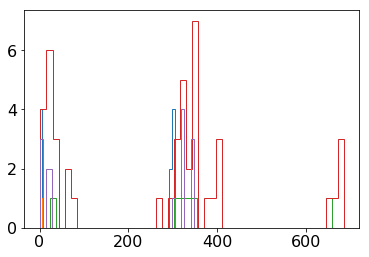

In [28]:
for dTarr in df.dT_tlim.values[:5]:
    plt.hist(dTarr, bins=50, histtype='step')

#### plot

['g', 'g'] 1439


[]

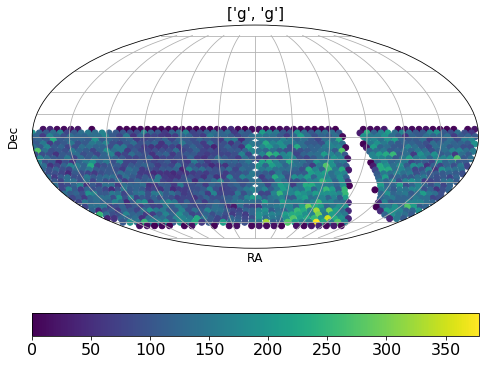

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);

ax = axs
#dbname = dblist_all[3]
#df = dataraw['{}{}'.format(f0,f1)][dbname]
ipix = df['pixId'].values

RA, Dec = pix2radec(nside=16, ipix=ipix)
c = df['Nv'].values

print(fltpair, len(c))
plot_mwd(ax, RA, Dec, c, title=fltpair, )
ax.set_xticklabels([])     
ax.set_yticklabels([]) 

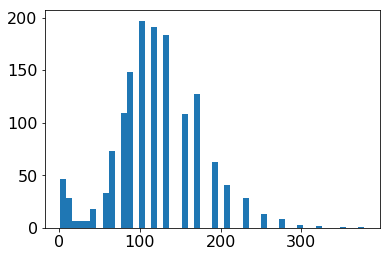

In [19]:
plt.hist(df.Nv, bins=50);

['g', 'g'] 1439


[]

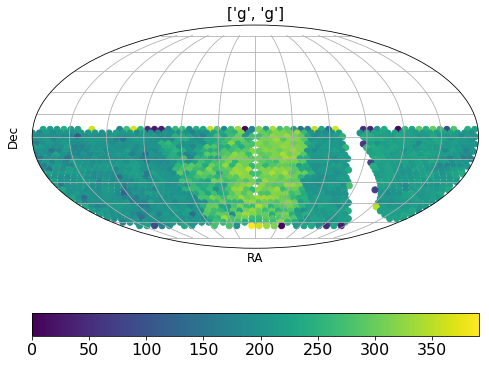

In [47]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8), subplot_kw={'projection': 'mollweide'}, )#constrained_layout=True);

ax = axs
#dbname = dblist_all[3]
#df = dataraw['{}{}'.format(f0,f1)][dbname]
ipix = df['pixId'].values

RA, Dec = pix2radec(nside=16, ipix=ipix)
# c = df['tmax'].values
c = df['dT_tlim'].apply(lambda x: np.mean(x))

#idx =  c<600 
print(fltpair, len(c))
plot_mwd(ax, RA[idx], Dec[idx], c[idx], title=fltpair, vmin=0, vmax=None)
ax.set_xticklabels([])     
ax.set_yticklabels([]) 


In [37]:
c<100

0       False
1        True
2       False
3       False
4       False
5       False
6       False
7       False
8       False
9       False
10      False
11      False
12      False
13       True
14       True
15       True
16      False
17      False
18      False
19      False
22      False
24      False
25      False
26      False
27      False
28      False
29      False
31      False
32      False
33      False
        ...  
1419    False
1420    False
1421    False
1422    False
1423    False
1424    False
1425    False
1426    False
1427    False
1429    False
1430    False
1432    False
1434    False
1435    False
1436    False
1437    False
1438     True
1439    False
1440    False
1441     True
1442    False
1443     True
1444    False
1445    False
1446    False
1447    False
1449     True
1450    False
1451    False
1452    False
Name: dT_tlim, Length: 1439, dtype: bool

Text(0.5, 0, 'delta T (day)')

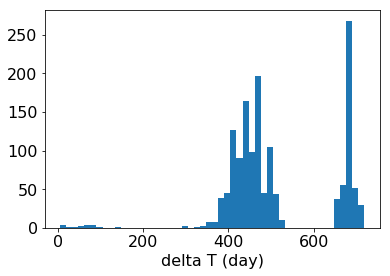

In [48]:
plt.hist(df.tmax.values, bins=50);
plt.xlabel('delta T (day)')
#plt.xscale('log')


In [16]:
def plot_mwd(ax, RA, Dec, c, org=0, title='Mollweide projection', projection='mollweide', vmin=0, vmax=None, colorbar=True):
    ''' RA, Dec are arrays of the same length.
    RA takes values in [0,360), Dec in [-90,90],
    which represent angles in degrees.
    org is the origin of the plot, 0 or a multiple of 30 degrees in [0,360).
    title is the title of the figure.
    projection is the kind of projection: 'mollweide', 'aitoff', 'hammer', 'lambert'
    
    Examples:
    >>> fig, ax = plt.subplots(1, 1, figsize=(8, 8), 
                            subplot_kw={'projection': 'mollweide'}); 
        plot_mwd(ax, x, y, c, title='') 
    '''
    if vmax is None:
        vmax = c.max()
    
    x = np.remainder(RA+360-org,360) # shift RA values
    ind = x>180
    x[ind] -=360    # scale conversion to [-180, 180]
    x=-x    # reverse the scale: East to the left
    tick_labels = np.array([150, 120, 90, 60, 30, 0, 330, 300, 270, 240, 210])
    tick_labels = np.remainder(tick_labels+360+org,360)
    # fig = plt.figure(figsize=(10, 5))
    # ax = fig.add_subplot(111, projection=projection, facecolor ='LightCyan')
    # ax = fig.add_subplot(111, projection=projection, facecolor ='honeydew')
    sc = ax.scatter(np.radians(x), np.radians(Dec), c=c, marker='o', vmin=vmin, vmax=vmax)  # convert degrees to radians
    ax.set_xticklabels(tick_labels)     # we add the scale on the x axis
    ax.set_title(title)
    ax.title.set_fontsize(15)
    ax.set_xlabel("RA")
    ax.xaxis.label.set_fontsize(12)
    ax.set_ylabel("Dec")
    ax.yaxis.label.set_fontsize(12)
    ax.grid(True)
    if colorbar:
        cbar = plt.colorbar(sc, ax=ax, orientation="horizontal")
    #cbar.set_clim(-2.0, 2.0)



In [17]:
def pix2radec(nside, ipix, degree=True):
    """from ipix to ra/dec"""
    
    theta, phi = hp.pix2ang(nside, ipix)
    ra = phi
    dec = np.pi/2. - theta
    if degree:
        ra = np.rad2deg(ra)
        dec = np.rad2deg(dec)
    return ra, dec